In [1]:
import datetime as dt
import math

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats as st

Набор данных представляет собой основные маршруты авиаперелетов в США за один месяц 2008-го года. В качестве модели распространения инфекции предлагается использовать SI (susceptible-infected) модель, в которой каждый аэропорт имеет два возможных состояния - “здоровый” или “зараженный”. Здоровый аэропорт может заразиться с некоторой вероятностью p (infection probability), если к нему прилетает самолет из зараженного города. Инфекция начинает распространение из некоторого стартового аэропорта и заканчивает распространение, когда все перелеты из датасета завершены.

### Часть 1. Пишем симуляцию

In [7]:
airports_df = pd.read_csv(".\\data\\US_airport_id_info.csv")

In [6]:
airports_df = airports_df[['id', 'airport name', 'city']]

In [7]:
airports_df.head()

,id,airport name,city
0,0,Lehigh Valley Intl,Allentown
1,1,Cleveland Hopkins Intl,Cleveland
2,2,Charlotte Douglas Intl,Charlotte
3,3,Chicago Ohare Intl,Chicago
4,4,Hartsfield Jackson Atlanta Intl,Atlanta


In [8]:
flights_df = pd.read_csv(".\data\events_US_air_traffic.txt", delimiter=" ")

In [9]:
flights_df = flights_df.dropna(axis=0)

In [10]:
flights_df["Start_Time"] = flights_df["StartTime"].apply(
    lambda element: dt.datetime.fromtimestamp(element)
)

In [11]:
flights_df["End_Time"] = flights_df["EndTime"].apply(
    lambda element: dt.datetime.fromtimestamp(element)
)

In [12]:
flights_df = flights_df.sort_values(by="Start_Time").reset_index(drop=True)

In [13]:
flights_df.head()

,Source,Destination,StartTime,EndTime,Duration,Start_Time,End_Time
0,27,49,1229231100,1.229247e+09,15660.0,2008-12-14 08:05:00,2008-12-14 12:26:00
1,30,2,1229233200,1.229246e+09,12780.0,2008-12-14 08:40:00,2008-12-14 12:13:00
2,251,20,1229235000,1.229246e+09,11340.0,2008-12-14 09:10:00,2008-12-14 12:19:00
3,12,4,1229235300,1.229245e+09,9660.0,2008-12-14 09:15:00,2008-12-14 11:56:00
4,180,20,1229235300,1.229246e+09,10200.0,2008-12-14 09:15:00,2008-12-14 12:05:00


In [15]:
num_of_iters = math.ceil(
    (
        (
            flights_df.loc[len(flights_df) - 1, "End_Time"]
            - flights_df.loc[0, "End_Time"]
        ).total_seconds()
        / 3600
    )
    / 12
)

In [16]:
flights_df.shape[0]

61371

Напишите функцию для симуляции одного прохода по всему датасету и распространения инфекции. 
Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. 
На выходе функция должна возвращать словарь, с котором ключом будет время заражения аэропорта, значением - название аэропорта. 
В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт.
В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0)

In [17]:
num_of_airports = len(airports_df["airport name"].unique())
num_of_airports

279

In [18]:
def simulation_step2(start_city, prob_of_infect):
    airports_dict = pd.DataFrame(columns={"airport_name", "infect_time"})
    airports_df["infected"] = np.zeros(len(airports_df))
    airports_df.loc[airports_df.city == start_city, "infected"] = 1
    start_simulation_time = None

    for flight in flights_df.itertuples():
        if start_simulation_time == None:
            start_simulation_time = (
                flight.Start_Time
            )  # старт симуляции - вылет первого рейса

        if (
            airports_df.loc[flight.Source, "infected"] == 1
        ):  # если аэропорт вылета заражен
            # если аэропорт прибытия еще не заражен, то аэропорт заражается с некоторой вероятностью
            if (np.random.random() < prob_of_infect) and (
                airports_df.loc[flight.Destination, "infected"] == 0
            ):  #

                airports_df.loc[flight.Destination, "infected"] = 1
                airport_name = airports_df.loc[flight.Destination, "airport name"]
                infect_time = flight.End_Time - start_simulation_time
                #                     airports_dict.update({infect_time:airport_name})
                airports_dict.loc[len(airports_dict), :] = [infect_time, airport_name]

    return airports_dict

### Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?

Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.
Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.


In [19]:
interm_stops = [12 * i for i in range(1, num_of_iters + 1)]

In [20]:
interm_stops

[12, 24, 36, 48, 60, 72, 84, 96, 108]

In [22]:
mean_results = pd.DataFrame(data=interm_stops, columns=["hours"])
p = [0.01, 0.05, 0.1, 0.5, 1.0]
for prob in p:
    all_results = pd.DataFrame(data=interm_stops, columns=["hours"])
    print("Probability:", prob)
    for i in range(10):
        simulation_result = simulation_step2("Allentown", prob)
        simulation_result.infect_time = [
            int(x.total_seconds() / 3600) for x in simulation_result.infect_time
        ]
        for j in range(len(all_results)):
            all_results.loc[j, str(i)] = len(
                simulation_result[simulation_result.infect_time <= all_results.hours[j]]
            )
    mean_results[str(prob)] = all_results.iloc[:, 1:].mean(axis=1)

Probability: 0.01
Probability: 0.05
Probability: 0.1
Probability: 0.5
Probability: 1.0


In [23]:
mean_results

,hours,0.01,0.05,0.1,0.5,1.0
0,12,0.0,0.5,18.8,175.8,252.0
1,24,0.9,24.3,103.6,255.1,276.0
2,36,3.0,67.4,141.1,262.9,276.0
3,48,7.7,117.7,177.5,271.8,277.0
4,60,13.4,133.8,186.9,273.7,277.0
5,72,24.5,164.8,213.7,275.1,277.0
6,84,31.0,174.0,219.9,275.3,277.0
7,96,39.4,183.3,226.1,275.7,277.0
8,108,39.5,183.3,226.1,275.7,277.0


In [24]:
mean_results.iloc[:, 1:] = mean_results.iloc[:, 1:] / num_of_airports * 100

In [25]:
mean_results

,hours,0.01,0.05,0.1,0.5,1.0
0,12,0.000000,0.179211,6.738351,63.010753,90.322581
1,24,0.322581,8.709677,37.132616,91.433692,98.924731
2,36,1.075269,24.157706,50.573477,94.229391,98.924731
3,48,2.759857,42.186380,63.620072,97.419355,99.283154
4,60,4.802867,47.956989,66.989247,98.100358,99.283154
5,72,8.781362,59.068100,76.594982,98.602151,99.283154
6,84,11.111111,62.365591,78.817204,98.673835,99.283154
7,96,14.121864,65.698925,81.039427,98.817204,99.283154
8,108,14.157706,65.698925,81.039427,98.817204,99.283154


<AxesSubplot: >

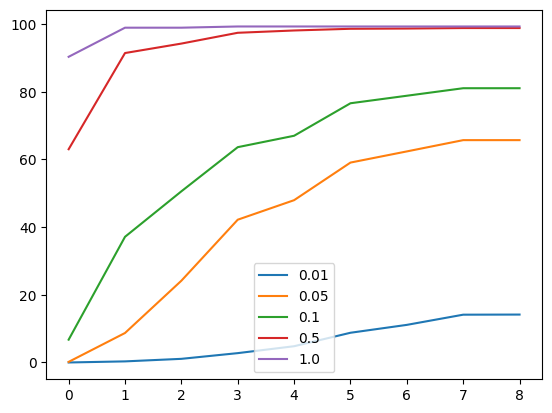

In [26]:
mean_results.iloc[:, 1:].plot()

### Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?

    По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.

In [27]:
flights_df["Path"] = np.zeros(len(flights_df))

In [28]:
for i in range(len(flights_df)):
    flights_df.loc[i, "Path"] = (
        str(min(flights_df.loc[i, "Source"], flights_df.loc[i, "Destination"]))
        + "_"
        + str(max(flights_df.loc[i, "Source"], flights_df.loc[i, "Destination"]))
    )

In [30]:
weighted_paths

,value,source,target
0,0.003797,55,56
1,0.003797,79,109
2,0.003617,11,14
3,0.003585,4,7
4,0.003454,109,110
...,...,...,...
2012,0.000016,133,155
2013,0.000016,1,81
2014,0.000016,3,246
2015,0.000016,1,87


In [31]:
weighted_paths = pd.DataFrame(data=flights_df["Path"].value_counts())
weighted_paths = weighted_paths.reset_index(drop=False)
weighted_paths[["source", "target"]] = weighted_paths["index"].str.split(
    "_", 1, expand=True
)
weighted_paths = weighted_paths.drop("index", axis=1)
weighted_paths = weighted_paths.rename({"Path": "value"}, axis=1)
weighted_paths.value = weighted_paths.value / weighted_paths.value.sum()

In [32]:
G = nx.from_pandas_edgelist(
    weighted_paths,
    source="source",
    target="target",
    edge_attr="value",
    create_using=nx.Graph(),
)

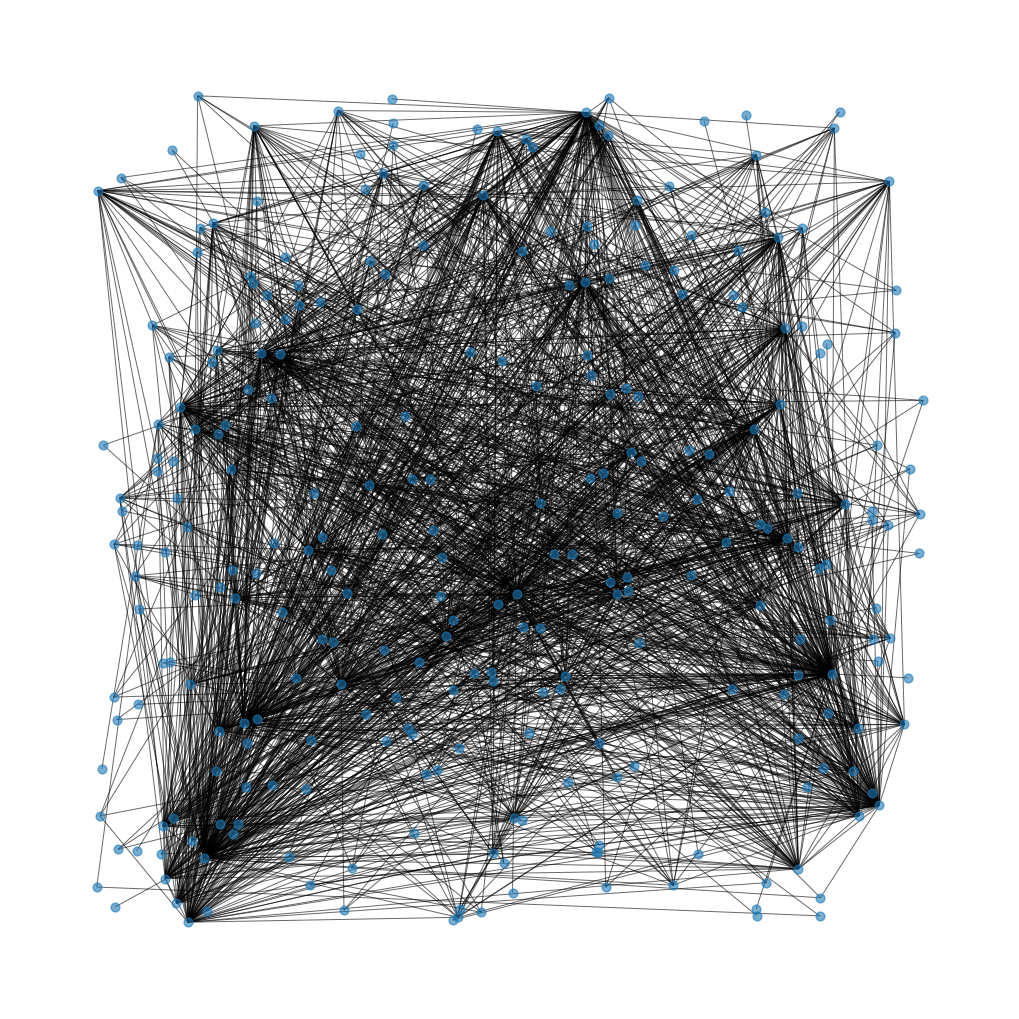

In [33]:
plt.figure(figsize=(10, 10))
pos = nx.random_layout(G, seed=23)
nx.draw(G, pos=pos, node_size=40, alpha=0.6, width=0.7)
plt.show()

    Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.

In [34]:
joined_results = pd.DataFrame(
    data=airports_df["airport name"].unique(), columns=["airport_name"]
)
for i in range(50):
    simulation_result = simulation_step2("Allentown", 0.5)
    joined_results = pd.merge(
        joined_results, simulation_result, how="outer", on="airport_name"
    )
    joined_results = joined_results.fillna(pd.Timedelta("10 days 00:00:00"))
    joined_results.infect_time = [
        int(x.total_seconds() / 60) for x in joined_results.infect_time
    ]
    joined_results = joined_results.rename({"infect_time": str(i)}, axis=1)
joined_results = joined_results.replace(14400, np.NaN)

In [35]:
joined_results["median"] = joined_results.median(axis=1)

C:\Users\alena\AppData\Local\Temp\ipykernel_7888\2968484558.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  joined_results["median"] = joined_results.median(axis=1)


In [36]:
joined_results.head()

,airport_name,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,median
0,Lehigh Valley Intl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cleveland Hopkins Intl,525.0,760.0,440.0,505.0,575.0,440.0,719.0,505.0,505.0,...,505.0,525.0,440.0,505.0,505.0,575.0,440.0,505.0,525.0,515.0
2,Charlotte Douglas Intl,505.0,881.0,436.0,436.0,436.0,436.0,760.0,393.0,436.0,...,372.0,476.0,372.0,372.0,372.0,495.0,495.0,372.0,516.0,476.0
3,Chicago Ohare Intl,420.0,783.0,450.0,450.0,420.0,450.0,749.0,420.0,450.0,...,430.0,450.0,420.0,420.0,430.0,462.0,430.0,450.0,684.0,450.0
4,Hartsfield Jackson Atlanta Intl,381.0,773.0,517.0,444.0,381.0,444.0,741.0,381.0,381.0,...,381.0,444.0,381.0,381.0,381.0,381.0,381.0,381.0,515.0,381.0


In [37]:
final_df = joined_results.loc[:, ["airport_name", "median"]].sort_values(
    by="median", ascending=False
)
final_df = final_df.reset_index(drop=False)
final_df["index"] = final_df["index"].astype(float)

    Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).

In [38]:
cluster_coeff = nx.algorithms.cluster.clustering(G)
cluster_coeff = (
    pd.DataFrame.from_dict(cluster_coeff, orient="index", dtype="float64")
    .reset_index(drop=False)
    .rename(columns={0: "cluster_coeff"})
)
cluster_coeff["index"] = cluster_coeff["index"].astype(float)

In [39]:
cluster_coeff.cluster_coeff.describe()

count    278.000000
mean       0.632572
std        0.411253
min        0.000000
25%        0.187032
50%        0.845871
75%        1.000000
max        1.000000
Name: cluster_coeff, dtype: float64

In [40]:
degrees = [G.degree(n) for n in G.nodes()]
degrees = dict(zip(G.nodes(), degrees))
degrees = (
    pd.DataFrame.from_dict(degrees, orient="index")
    .reset_index(drop=False)
    .rename(columns={0: "degrees"})
)
degrees["index"] = degrees["index"].astype(float)

In [41]:
degrees.degrees.describe()

count    278.000000
mean      14.510791
std       23.814526
min        1.000000
25%        2.000000
50%        4.000000
75%       15.000000
max      147.000000
Name: degrees, dtype: float64

In [42]:
centrality = nx.algorithms.centrality.betweenness_centrality(G)
centrality = (
    pd.DataFrame.from_dict(centrality, orient="index")
    .reset_index(drop=False)
    .rename(columns={0: "centrality"})
)
centrality["index"] = centrality["index"].astype(float)

In [43]:
centrality.centrality.describe()

count    278.000000
mean       0.005055
std        0.021209
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000103
max        0.213784
Name: centrality, dtype: float64

In [44]:
final_df = pd.merge(final_df, cluster_coeff, how="outer", on="index")
final_df = pd.merge(final_df, degrees, how="outer", on="index")
final_df = pd.merge(final_df, centrality, how="outer", on="index")

In [45]:
final_df

,index,airport_name,median,cluster_coeff,degrees,centrality
0,240.0,Ithaca Tompkins Rgnl,2690.0,0.000000,1.0,0.000000
1,277.0,Rhinelander Oneida County Airport,2348.0,0.000000,1.0,0.000000
2,54.0,Merle K Mudhole Smith,2323.0,0.000000,2.0,0.000874
3,188.0,Yakutat,2231.0,0.000000,2.0,0.000058
4,182.0,Wiley Post Will Rogers Mem,2176.0,1.000000,3.0,0.000000
...,...,...,...,...,...,...
274,110.0,Ronald Reagan Washington Natl,423.0,0.589372,46.0,0.002631
275,124.0,Dane Co Rgnl Truax Fld,410.0,0.961538,13.0,0.000003
276,4.0,Hartsfield Jackson Atlanta Intl,381.0,0.137639,147.0,0.213784
277,0.0,Lehigh Valley Intl,NaN,1.000000,5.0,0.000000


In [46]:
final_df = final_df.dropna()

    Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?

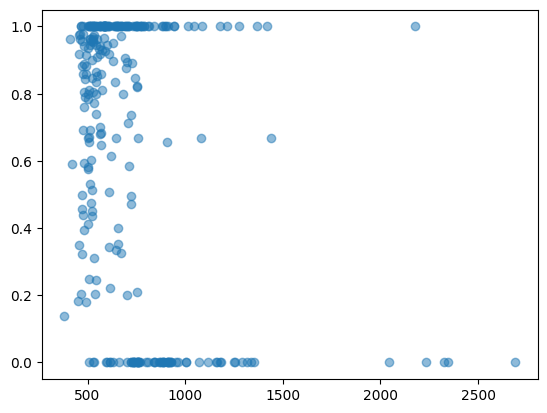

In [47]:
plt.scatter(final_df["median"].values, final_df.cluster_coeff, alpha=0.5)

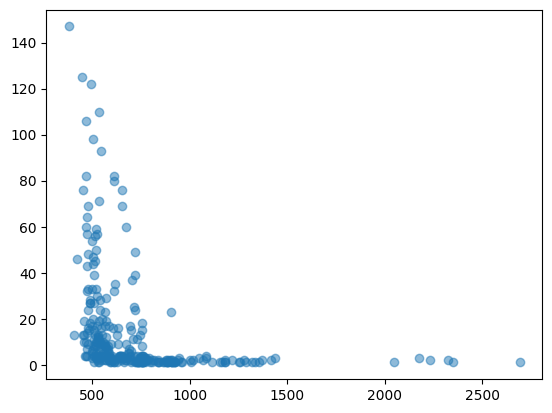

In [48]:
plt.scatter(final_df["median"].values, final_df.degrees, alpha=0.5)

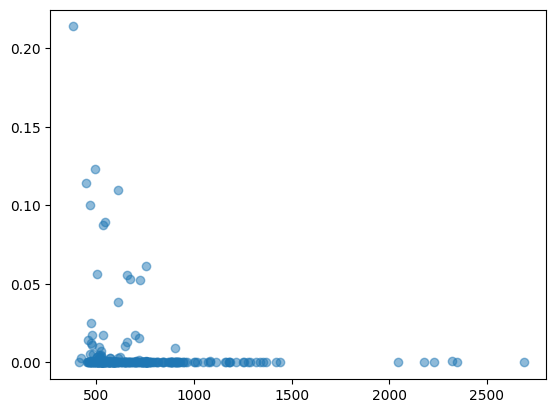

In [49]:
plt.scatter(final_df["median"].values, final_df.centrality, alpha=0.5)

Коэффициент корреляции Спирмена принимает значения из отрезка [-1;1]. Равенство 1 указывает на строгую прямую линейную зависимость, -1 на обратную.

In [50]:
st.spearmanr(final_df["median"].values, final_df.cluster_coeff)

SpearmanrResult(correlation=-0.21110385400361148, pvalue=0.0004038888131566085)

In [51]:
st.spearmanr(final_df["median"].values, final_df.degrees)

SpearmanrResult(correlation=-0.688539233998294, pvalue=2.9374611236651695e-40)

In [52]:
st.spearmanr(final_df["median"].values, final_df.centrality)

SpearmanrResult(correlation=-0.49664954609961726, pvalue=1.1678038344794933e-18)

    Со временем заражения сильнее всего скоррелирована степень вершины: чем больше степень вершины, то есть число городов, с которыми есть рейсы, тем меньше время, необходимое для заражения города.
    Также, чем больше метрика betweenness_centrality вершины (число кратчайших путей через вершину), тем меньше время, необходимое для заражения города.